In [1]:
import yaml
import re
import enum
from pprint import pprint, pformat
from tabulate import tabulate
import itertools
import random
import math
import time
import json

from dataclasses import dataclass
from typing import List, Tuple, Set
from copy import copy, deepcopy

def parse_spec(file_path):
  with open(file_path, 'r') as file_handle:
    spec = yaml.safe_load(file_handle)
  return spec

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
ex_spec = parse_spec('video-editor.yaml')

## Comparing Objects

In [4]:
# TODO: refactor to use listable instead of this function
def process_listable(target, func):
  if target is None:
    return

  if type(target) == list:
    for target_item in target:
      func(target_item)
  else:
    func(target)

# Return a list even if it's a single thing, so you can always loop through it
def listable(content):
  if type(content) in [str, dict]:
    return [content]
  elif type(content) is list:
    return content
  elif content is None:
    return []
  else:
    print('Listable item is of type:', type(content))
    assert(False)

def strip_type(obj):
  return re.sub(r'\((\w|-)*\) ', '', obj)


In [5]:
def split_object_signature(obj_signature: str):
  # NOTE: assumes that the signature doesn't start with a punctuation. 
  assert '->' not in obj_signature, 'Object signature cannot have `->` in it (yet).'
  # TODO: trivial to add -> as a separator, just don't need to yet.
  return list(zip(
        re.split(r"[\w\-_ ]+", obj_signature)[:-1], # get all the `.` and `/` (last is empty)
        re.split(r"\.|/", obj_signature)         # get all the words
      ))

def recombine_object_signature(split_object: list[tuple[str, str]]):
  res = ''
  for punct, term in split_object:
    res += punct + term
  return res

def test_obj_signature(test):
  print('testing: ' + test)
  print(list(split_object_signature(test)))
  result = recombine_object_signature(split_object_signature(test))
  print(result)
  print(test == result)
  print()

test_obj_signature('')
test_obj_signature('alpha.beta-thing.cool')
test_obj_signature('alpha-thing/beta/cool')
test_obj_signature('alpha-thing.beta_stuff/cool dude/yeah.man')
test_obj_signature('videos.in-editor/images')

# test_obj_signature('not->this')


testing: 
[]

True

testing: alpha.beta-thing.cool
[('', 'alpha'), ('.', 'beta-thing'), ('.', 'cool')]
alpha.beta-thing.cool
True

testing: alpha-thing/beta/cool
[('', 'alpha-thing'), ('/', 'beta'), ('/', 'cool')]
alpha-thing/beta/cool
True

testing: alpha-thing.beta_stuff/cool dude/yeah.man
[('', 'alpha-thing'), ('.', 'beta_stuff'), ('/', 'cool dude'), ('/', 'yeah'), ('.', 'man')]
alpha-thing.beta_stuff/cool dude/yeah.man
True

testing: videos.in-editor/images
[('', 'videos'), ('.', 'in-editor'), ('/', 'images')]
videos.in-editor/images
True



In [6]:
# NOTE: This is mostly used as a parser to get all of the objects. It was previously used to do more stuff, but it's not
# really worth the refactor right now.
class ObjectRegistry(object):
  # obj mapto obj registry
  # {obj name: set(obj names)}
  registry: dict[str, Set[str]] = {}
  structures: set = set()
  
  # # registry for structures between structures, repr, etc.
  # # {obj name: set((entity-name, connection-type), etc...) }
  # connections: dict[str, Set[Tuple[str, str]]] = {}

  def __init__(self, spec=None):
    self.registry = {}
    self.structures = set()
    if spec is not None:
      self.register_spec_objects(spec)

  def __str__(self):
    return pformat(self.registry)

  def register_object(self, obj):
    # in order of priority
    # -> means mapto
    # . means subset
    # / means component
    assert(type(obj) is str)
    obj = strip_type(obj)

    arrow_array = obj.split('->')
    for arrow_idx, arrow_term in enumerate(arrow_array):
      
      # dot_array = arrow_term.split('.')
      # dot_array = re.split(r"\.|/", arrow_term) # split on `.` and `/`
      dot_array = split_object_signature(arrow_term)
      for dot_idx, dot_term in enumerate(dot_array):

        # subject = '.'.join(dot_array[:dot_idx + 1]) # join up to idx
        subject = recombine_object_signature(dot_array[:dot_idx + 1]) # join up to idx
        if not self.registry.get(subject):
          self.registry[subject] = set()
        
        if dot_idx > 0:
          # every sequence maps to the previous element eg. a.b.c => {a.b.c: {a.b}, a.b: {a}}
          # previous = '.'.join(dot_array[:dot_idx])
          previous = recombine_object_signature(dot_array[:dot_idx])
          self.registry[subject].add(previous)
      
      if arrow_idx > 0:
        # a pair of arrows lhs->rhs => {lhs: {rhs}}
        lhs = self.registry[arrow_array[arrow_idx - 1]]
        rhs = arrow_array[arrow_idx]
        lhs.add(rhs)

  def register_struct_objects(self, struct, process_func):
    if struct.get('type') == 'group':
      # Groups also behave as objects, so register them
      name = struct.get('name')
      if name is None:
        print('Warning! No name provided for group. Using `NO NAME PROVIDED` instead. TODO: generate ID.')
        name = 'NO NAME PROVIDED'

      if self.registry.get(name) is None:
        self.registry[name] = set()
      
      # TODO: do groups map to their elements? Really, does the transitive property apply? My hunch is no, but need to think more

    process_listable(struct.get('affects'), process_func)
    process_listable(struct.get('covered-by'), process_func)
    # TODO: relate all of the objects affected/covered by a structure. 

    for derivative in struct.get('structures', []):
      self.register_struct_objects(derivative, process_func=process_func)

  def register_repr_objects(self, repr, process_func):
    repr_type = repr.get('type', '')
    # print(repr_type)
    for repr_item in repr.get('objects', []):
      assert(type(repr_item) is dict)
      assert(len(list(repr_item.keys())) == 1)
      repr_obj = list(repr_item.keys())[0]


      if type(repr_item[repr_obj]) is str:
        # turn str into list to iterate through it properly
        repr_item[repr_obj] = [repr_item[repr_obj]]

      # assert(len(repr_item.values()) == 1)
      # repr_obj, target_objs = list(repr_item.items())[0]
      for target_obj in repr_item[repr_obj]:
        process_func(target_obj)
        # Map every item to the associated representational object
        # eg. {message: {textbox}, author: {textbox}}
        if self.registry.get(target_obj) is None:
          self.registry[target_obj] = set()
        self.registry[target_obj].add(repr_obj)
        # objects[target].add(repr_type + '/' + repr_obj)  # when we prefix the core stuff
        # note: this is a bit backwards compared to the syntax!


  def register_spec_objects(self, spec): # {object: [mapto-targets]}
    def register_object_here(target):
      self.register_object(target)
    
    process_listable(spec.get('objects'), register_object_here)
    # TODO: deal with `objects` block

    for struct in spec.get('structures', []):
      struct_name = struct.get('name', None)
      if struct_name is not None:
        self.structures.add('struct_name')
      self.register_struct_objects(struct, register_object_here)
      
    for repr in spec.get('representations', []):
      self.register_repr_objects(repr, register_object_here)

    self.register_action_objects(spec)

  def register_action_objects(self, spec):
    # NOTE: this needs to be called after register_spec_objects
    if len(spec.get('structures', [])) > 0:
      assert self.structures != set(), "didn't collect structures"

    for behavior in listable(spec.get('behavior', [])):
      # - input → action
      # - triggers ← action (transitive)
      # NOTE: these aren't objects, so don't deal with them here
      
      # - edits → object | struct
      for edited in listable(behavior.get('edits', [])):
        if edited not in self.structures:
          # edit blocks can apply to structures, so don't add these to 
          self.register_object(edited)

      # - moves → obj | cover
      for move in listable(behavior.get('moves', [])):
        if move_target := move.get('object'):
          self.register_object(move_target)

      


In [7]:
def test_obj_registration(test_input, expected):
  print('testing:', test_input)
  test = ObjectRegistry()
  print('expected:')
  pprint(expected)
  print('got:')
  test.register_object(test_input)
  print(test)
  print()

In [8]:
# Test arrows and dots in Object Registry
# test_obj_registration(
#   test_input='',
#   expected={'': set()}
# )

test_obj_registration(
  test_input='a',
  expected={'a': set()}
)

test_obj_registration(
  test_input='a.b.c',
  expected={'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}
)

test_obj_registration(
  test_input='a->b->c',
  expected={'a': {'b'}, 'b': {'c'}, 'c': set()}
)

test_obj_registration(
  test_input='a.b->x->z.w',
  expected={'a': set(), 'a.b': {'x', 'a'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}
)

testing: a
expected:
{'a': set()}
got:
{'a': set()}

testing: a.b.c
expected:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}
got:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}}

testing: a->b->c
expected:
{'a': {'b'}, 'b': {'c'}, 'c': set()}
got:
{'a': {'b'}, 'b': {'c'}, 'c': set()}

testing: a.b->x->z.w
expected:
{'a': set(), 'a.b': {'x', 'a'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}
got:
{'a': set(), 'a.b': {'x', 'a'}, 'x': {'z.w'}, 'z': set(), 'z.w': {'z'}}



In [9]:
# Tests for components
test_obj_registration(
  test_input='a/x',
  expected={'a': set(), 'a/x': {'a'}}
)

test_obj_registration(
  test_input='a.b.c/x',
  expected={'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}, 'a.b.c/x': {'a.b.c'}}
)

test_obj_registration(
  test_input='a->b/x',
  expected={'a': {'b/x'}, 'b/x': {'b'}, 'b': set()}
)

test_obj_registration(
  test_input='a/x->b',
  expected={'a/x': {'b', 'a'}, 'a': set(), 'b': set()}
)

test_obj_registration(
  test_input='x.sub/attr->y',
  expected={'x.sub/attr': {'y', 'x.sub'}, 'x.sub': {'x'}, 'x': set(), 'y': set()}
)

testing: a/x
expected:
{'a': set(), 'a/x': {'a'}}
got:
{'a': set(), 'a/x': {'a'}}

testing: a.b.c/x
expected:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}, 'a.b.c/x': {'a.b.c'}}
got:
{'a': set(), 'a.b': {'a'}, 'a.b.c': {'a.b'}, 'a.b.c/x': {'a.b.c'}}

testing: a->b/x
expected:
{'a': {'b/x'}, 'b': set(), 'b/x': {'b'}}
got:
{'a': {'b/x'}, 'b': set(), 'b/x': {'b'}}

testing: a/x->b
expected:
{'a': set(), 'a/x': {'a', 'b'}, 'b': set()}
got:
{'a': set(), 'a/x': {'a', 'b'}, 'b': set()}

testing: x.sub/attr->y
expected:
{'x': set(), 'x.sub': {'x'}, 'x.sub/attr': {'y', 'x.sub'}, 'y': set()}
got:
{'x': set(), 'x.sub': {'x'}, 'x.sub/attr': {'y', 'x.sub'}, 'y': set()}



In [10]:
'a.b/c.d/x'.split('.')
# re.split(r"[\w\-_]+", 'a-e.b/c-o.d/x')
print(re.split(r"\.|/", 'a-e.b/c-o.d/x'))
print(re.split(r"[\w\-_ ]+", 'a-e.b/c-o.d/x')[1:])

list(zip(re.split(r"\.|/", 'a-e.b/c-o.d/x'), re.split(r"[\w\-_ ]+", 'a-e.b/c-o.d/x')[1:]))

['a-e', 'b', 'c-o', 'd', 'x']
['.', '/', '.', '/', '']


[('a-e', '.'), ('b', '/'), ('c-o', '.'), ('d', '/'), ('x', '')]

In [11]:
print('testing: days.selected->events')
print('expected:')
pprint({'days.selected': {'events', 'days'}, 'days': set(), 'events': set()})

print('got:')
test = ObjectRegistry()

test.register_object('days.selected->events')
print(test)

print()
test_obj_registration(
  test_input='playhead->videos.in-editor/images',
  expected={'videos': set(), 'videos.in-editor': {'videos'}, 'videos.in-editor/images': {'videos.in-editor'}, 'playhead': {'videos.in-editor/images'}}
)


testing: days.selected->events
expected:
{'days': set(), 'days.selected': {'events', 'days'}, 'events': set()}
got:
{'days': set(), 'days.selected': {'events', 'days'}, 'events': set()}

testing: playhead->videos.in-editor/images
expected:
{'playhead': {'videos.in-editor/images'},
 'videos': set(),
 'videos.in-editor': {'videos'},
 'videos.in-editor/images': {'videos.in-editor'}}
got:
{'playhead': {'videos.in-editor/images'},
 'videos': set(),
 'videos.in-editor': {'videos'},
 'videos.in-editor/images': {'videos.in-editor'}}



In [12]:
ex_obj_registry = ObjectRegistry()
ex_obj_registry.register_spec_objects(ex_spec)
print(ex_obj_registry)

{'playhead': {'timestamps', 'videos.in-editor/images', 'vlines'},
 'playhead->videos.in-editor/images': {'rects'},
 'timestamps': {'vlines'},
 'tracks': {'regions'},
 'videos': set(),
 'videos.in-editor': {'rects', 'videos'},
 'videos.in-editor.selected': {'videos.in-editor'},
 'videos.in-editor/images': {'videos.in-editor'},
 'videos/first-frame': {'regions', 'videos'}}


In [13]:
core_spec = parse_spec('core.yaml')
core_objs = ObjectRegistry()

# TODO: probably need to consider prefixing gui on these
for repr_type in core_spec.get('representation-types', []):
  # print(repr_type['name'])
  core_objs.register_spec_objects(repr_type)

# register_spec_objects(core_spec, core_objs)
print(core_objs)

{'hlines': {'lines'},
 'icons': {'regions'},
 'lines': {'regions'},
 'points': set(),
 'rects': {'regions'},
 'regions': set(),
 'vlines': {'lines'}}


In [14]:
# NOTE: this is made redundant by the transitive closure of the graph
# NOTE: This is general! Assuming your relations/registry is shaped properly
# TODO: count depth
def get_node_join(left, right, relations, visited=set(), depth=0) -> str | None:
  assert(type(left) is str)
  assert(type(right) is str)
  
  if relations.get(left) is None or relations.get(right) is None:
    return None

  # Trace print
  # print(f"{left:<8} {right:<}")

  if left in visited or right in visited:
    # To avoid cycles, abort if we've already visited a node
    # NOTE: Not like 100% sure this is clean
    print("WARNING! Cycle detected in the relations.")
    return None

  if left == right:
    return left
  
  for next_left in relations[left]:
    left_res = get_node_join(next_left, right, relations, visited=visited)
    if left_res is None:
      # When you reach the leaf of a spanning tree, pop back up to recurse
      for next_right in relations[right]:
        return get_node_join(left, next_right, relations, visited=visited)
    else:
      return left_res

  if len(relations[right]) == 0 and len(relations[left]) == 0:
    return None

print()
print('vlines, hlines => ' + str(get_node_join('vlines', 'hlines', core_objs.registry)))
print('rects, hlines => ' + str(get_node_join('rects', 'hlines', core_objs.registry)))
print('points, hlines => ' + str(get_node_join('points', 'hlines', core_objs.registry)))


vlines, hlines => lines
rects, hlines => regions
points, hlines => None


## Comparing Structures
- need to show that two structures are "the same" based on their types
- do structures map to other structures

In [15]:
class StructRegistry(object):
  # Keep track of the type of each structure
  # TODO: I guess you only ever have the one type huh? keeping it a set for now
  # so that I can use get_node_join() without changing it.
  typeRegistry: dict[str, Set[str]] = {}

  # Keep track of which structure maps to which
  mapRegistry: dict[str, Set[str]] = {}

  def __init__(self, spec=None, core_spec=None):
    self.typeRegistry = {}
    self.mapRegistry = {}
    if spec is not None:
      self.register_spec(spec)
    
    if core_spec is None:
      # HACK: this probably shouldn't be hard-coded
      self.core_spec = parse_spec('core.yaml')
  
  def _prefix(parents: List[str]):
    return '/'.join(parents) + '/'

  def register_struct(self, struct, parents=None):
    name = struct.get('name')
    assert(name is not None)

    # TODO: do prefixes for structure components
    prefix = '' if parents is None else self._prefix(parents)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    if struct_type := struct.get('type'):
      self.typeRegistry[name].add(struct_type) 

    # Register map
    if self.mapRegistry.get(name) is None:
      self.mapRegistry[name] = set()
    
    if struct_maps := struct.get('mapto'):
      def process_struct_map(target):
        self.mapRegistry[name].add(target)
      
      process_listable(struct_maps, process_struct_map)
    
    # Registrer connections for objects
    # TODO
  
  def register_spec(self, spec, parents=None):
    for struct_type in core_spec.get('structure-types', []):
      self.register_struct_type(struct_type)

    for struct in spec.get('structures', []):
      self.register_struct(struct, parents)
  
  def register_struct_type(self, struct_type):
    # TODO: not 100% sure about how the semantics are being used (ie. type mapto is like a type for structure)
    name = struct_type.get('name')
    assert(name is not None)

    # Register type
    if self.typeRegistry.get(name) is None:
      self.typeRegistry[name] = set()
    
    # HACK: for the sake of comparing the type of structures from two different specs, it's easiest to think of
    # component-mapto as a type relation 
    if target := struct_type.get('mapto'):
      self.typeRegistry[name].add(target)
      
      

In [16]:
print(re.search("\(([\w-]+)\) (.*)", '(text) name->thing.stuff/yep').groups())

('text', 'name->thing.stuff/yep')


# Networkx Exploration
## Heuristic Metrics
We could try to prune possible matches using heuristics. Some metrics that come to mind:
- outgoing degree of nodes
- incoming degree of nodes (how many ancestors, fewer is better?)
- ???

How important is an object?  
- it maps to a bunch of stuff
- it has subsets
- it (or a subset) is represented

How important is a structure?
- it affects a bunch of stuff
- it has multiple covers

In [17]:
def draw_graph(graph, edge_relation):
  # Adapted from: https://stackoverflow.com/questions/20381460/how-to-draw-node-and-edge-attributes-in-a-networkx-graph
  # num_nodes = len(graph.nodes)
  # pos = nx.spring_layout(graph, k=4/(num_nodes**(0.5)), seed=0)  # Precompute positions (layout)
  # label_pos = {n: (x, y+0.15) for n, (x,y) in pos.items()}

  # This is a slightly nicer layout but super buggy
  pos = nx.kamada_kawai_layout(graph)  # Precompute positions (layout)
  label_pos = {n: (x, y+0.01) for n, (x,y) in pos.items()}

  # get edge and node attributes
  edge_labels = nx.get_edge_attributes(graph, edge_relation)
  node_states = nx.get_node_attributes(graph, edge_relation)

  # fig, ax = plt.plot()

  # draw graph
  nx.draw_networkx(graph, pos, with_labels=False)
  # draw node state labels
  nx.draw_networkx_labels(graph, label_pos, font_color='black')
  # draw edge attributes
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

  # TODO: make offset labels fit
  # # adjust axes to fit offset labels
  # ax[1].set_ylim(tuple(i*1.1 for i in ax[1].get_ylim()))

  # plt.show()


DiGraph with 2 nodes and 1 edges
['hello', 'world']
[('hello', 'world')]
{('hello', 'world'): 'space'}


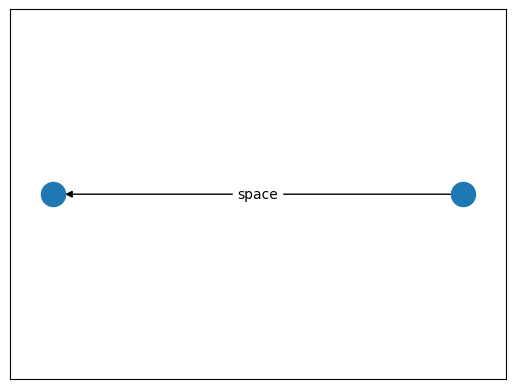

In [18]:
test_graph = nx.DiGraph()
test_graph.add_node('hello')
test_graph.add_node('hello')
test_graph.add_node('world')
test_graph.add_edge('hello', 'world', relation='space')
print(test_graph)
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

# nx.draw(test_graph, with_labels=True)
draw_graph(test_graph, 'relation')

In [19]:
nx.kamada_kawai_layout(test_graph)

{'hello': array([1.00000000e+00, 4.37113883e-08]),
 'world': array([-1.00000000e+00, -4.37113883e-08])}

[1, 2, 3, 4]
[(1, 2), (2, 3), (2, 4)]

[1, 2, 3, 4]
[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)]
{(1, 2): 'a', (2, 3): 'b', (2, 4): 'c'}


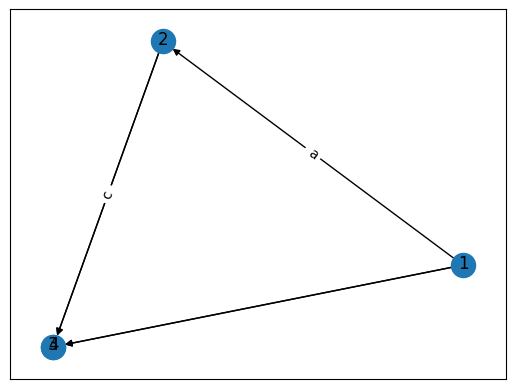

In [20]:
test_graph = nx.DiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'relation': 'a'}), (2,3, {'relation': 'b'}), (2, 4, {'relation': 'c'})])

print(test_graph.nodes)
print(test_graph.edges)

test_graph = nx.transitive_closure(test_graph, reflexive=False)
print()
print(test_graph.nodes)
print(test_graph.edges)
print(nx.get_edge_attributes(test_graph, 'relation'))

draw_graph(test_graph, 'relation')


[1, 2, 3, 4, 10, 20]
[(1, 2, 0), (1, 2, 1), (1, 10, 0), (2, 3, 0), (2, 20, 0), (3, 4, 0)]
{(1, 2, 0): 'a', (1, 2, 1): 'b', (1, 10, 0): 'b', (2, 3, 0): 'a', (2, 20, 0): 'b', (3, 4, 0): 'a'}


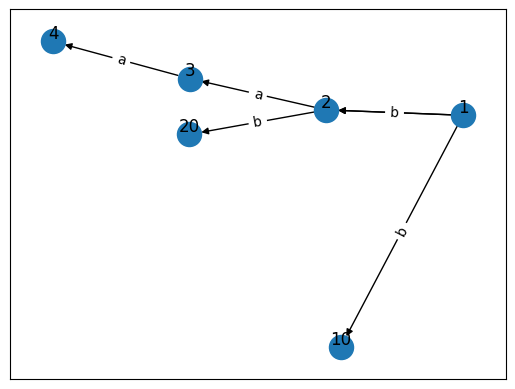

In [21]:
# NOTE: source need to be 
test_graph = nx.MultiDiGraph()
test_graph.add_nodes_from([1,2,3,4])
test_graph.add_edges_from([(1,2, {'rel': 'a'}), (2,3, {'rel': 'a'}), (3, 4, {'rel': 'a'})])

other_graph = nx.MultiDiGraph()
other_graph.add_nodes_from([1,2,3,10,20])
test_graph.add_edges_from([(1,2, {'rel': 'b'}), (1,10, {'rel': 'b'}), (2, 20, {'rel': 'b'})])

composed_graph = nx.compose(test_graph, other_graph)
print(composed_graph.nodes)
print(composed_graph.edges)
print(nx.get_edge_attributes(composed_graph, 'rel'))

draw_graph(composed_graph, 'rel')

In [22]:
test_graph = nx.DiGraph()
test_graph.add_edges_from([(1,2, {'rel': 'mapto'}), (2, 3, {'rel': 'mapto'})])
print(list(test_graph.edges.data()))
test_graph = nx.transitive_closure(test_graph)
print(list(test_graph.edges.data()))
print([(u, v, attr) for (u, v, attr) in test_graph.edges.data() if attr == {}])
nx.set_edge_attributes(test_graph, 'mapto', 'rel')
print(list(test_graph.edges.data()))

[(1, 2, {'rel': 'mapto'}), (2, 3, {'rel': 'mapto'})]
[(1, 2, {'rel': 'mapto'}), (1, 3, {}), (2, 3, {'rel': 'mapto'})]
[(1, 3, {})]
[(1, 2, {'rel': 'mapto'}), (1, 3, {'rel': 'mapto'}), (2, 3, {'rel': 'mapto'})]


In [23]:
def repr_obj_mapto_graph():
  core_mapto = nx.DiGraph()
  core_mapto.add_nodes_from(
    ['vlines', 'hlines', 'lines', 'rects', 'regions', 'icons', 'textboxes'],
    ilk='object'
  )

  # regions is the terminal object
  for node in core_mapto.nodes:
    if node == 'regions':
      continue
    core_mapto.add_edge(node, 'regions')

  # add any other relavent relations
  core_mapto.add_edges_from([
    ('hlines', 'lines'),
    ('vhlines', 'lines'),
  ])

  return core_mapto

def add_repr_obj_maps(spec_mapto: nx.digraph):
  # sorry about the bad name
  core_mapto = repr_obj_mapto_graph()

  # add a core_mapto edge if both nodes are in target_mapto. So this doesn't add
  # any nodes.
  for core_node in core_mapto.nodes:
    if core_node in spec_mapto.nodes: # core_node is in both
      for target_node in core_mapto.successors(core_node):
        if target_node in spec_mapto.nodes: # target_node is in both
          # print('adding', core_node, '->', target_node)
          spec_mapto.add_edge(core_node, target_node, rel='mapto')


In [24]:
def make_spec_graphs(spec):
  graphs = {
    'mapto': nx.DiGraph(),
    'affects': nx.DiGraph(),
    'covers': nx.DiGraph(),
    'behavior': nx.DiGraph(),
  }

  obj_registry = ObjectRegistry(spec)
  
  for lhs, rhs_set in obj_registry.registry.items():
    # lhs = sanitize_name(lhs)
    for rhs in rhs_set:
      # rhs = sanitize_name(rhs)
      # Add mapto
      # print(f'adding: {lhs} -mapto-> {rhs}')
      graphs['mapto'].add_nodes_from([lhs, rhs], ilk='object')
      graphs['mapto'].add_edge(lhs, rhs, rel='mapto')

  # # Add representational object relations
  # # NOTE: right now this only adds computational time, doesn't get better results
  # # so I'll keep it commented for now.
  # add_repr_obj_maps(graphs['mapto'])

  # Rule: Transitive closure on mapto
  graphs['mapto'] = nx.transitive_closure(graphs['mapto'])

  # Transitive closure doesn't transfer attributes, so they need to be added back.
  # If we want to label these newly added edges, we could do it hear by looping through something like
  # [(u, v, attr) for (u, v, attr) in test_graph.edges.data() if attr == {}]
  for (source, target, attr) in graphs['mapto'].edges.data():
    if attr == {}: # edges that were added by transitive closure
      graphs['mapto'][source][target]['rel'] = 'mapto'
      graphs['mapto'][source][target]['inference'] = 'mapto-transitive'

  # nx.set_edge_attributes(graphs['mapto'], 'mapto', 'rel')
 
  # NOTE: this is to deal with `types` eventually
  for obj in listable(spec.get('objects', [])):
    match = re.search("\(([\w-]+)\) (.*)", obj) # matches: (obj_type) obj_name
    if match is None:
      continue
    obj_type, obj_name = match.groups()
    obj_name = obj_name.split('->')[0].split('.')[0] 
    # prolog.append(f'type({obj_name}, {obj_type}).')
    # TODO: add type to a graph


  for struct in spec.get('structures', []):
    # struct_name = sanitize_name(struct.get('name', None))
    struct_name = struct.get('name', None)
    graphs['affects'].add_node(struct_name, ilk='structure')

    if struct_type := struct.get('type'):
      # prolog.append(f'type({struct_name}, {struct_type}).')
      # TODO
      pass

    for affected in listable(struct.get('affects', [])):
      # prolog.append(f'affects({struct_name}, {affected}).')
      graphs['affects'].add_node(affected, ilk='object')
      graphs['affects'].add_edge(struct_name, affected, rel='affects')
      
      # Rule: S affects A & A mapto B => S affects B
      if affected in graphs['mapto'].nodes:
        for knock_on_affected in graphs['mapto'].neighbors(affected):
          # TODO: right now, this doesn't propagate to subsets
          # that rule would be something like S affects B & A mapto B => S affects A
          # print(f'affected-mapto Rule adds: {struct_name} -affects-> {knock_on_affected}')
          graphs['affects'].add_node(knock_on_affected, ilk='object')
          graphs['affects'].add_edge(struct_name, knock_on_affected, rel='affects', inference='affect-mapto-composition')
    
    for cover in listable(struct.get('covered-by', [])):
      # prolog.append(f'covered_by({struct_name}, {cover}).')
      graphs['covers'].add_node(cover, ilk='object')
      graphs['covers'].add_node(struct_name, ilk='structure')
      graphs['covers'].add_edge(cover, struct_name, rel='covers')
  
  for behavior in spec.get('behavior', []):
    # There may be multiple actions with the same spec, so they each have the same relations.
    for action_name in listable(behavior.get('name', [])):
      pass
      # graphs['behavior'].add_node(action_name, ilk='action')
      
      # input → action
      # NOTE: how useful is this for matching? not really...
      # for input_ref in listable(behavior.get('input', [])):
      #   input_name = input_ref.get('name', None)

      #   # NOTE: this should probably be removed, depends on the syntax.
      #   if 'when' in input_name:
      #     old_input_name = input_name
      #     input_name = input_name.split(' when ')[0]
      #     print(f'warning: spliting input name on when: `{old_input_name}` -> `{input_name}`')

      #   assert input_name is not None, 'input name not defined'
      #   graphs['behavior'].add_node(input_ref, ilk='action', input_action=True) # TODO: this should be defined by core somehow
      #   graphs['behavior'].add_edge(input_ref, action_name, rel='triggers')

      # triggers ← action (transitive)
      # TODO: not really used yet

      # # edits → object | struct
      # for edited in listable(behavior.get('edits')):
      #   graphs['behavior'].add_edge(action_name, edited, rel='edits')

      # # moves → obj | cover
      # # moves → struct
      # for move in listable(behavior.get('moves')):
      #   if target := move.get('object', None):
      #     graphs['behavior'].add_edge(action_name, target, rel='move-object')
      #   else:
      #     print('move is missing a target')
        
      #   if along := move.get('along', None):
      #     graphs['behavior'].add_edge(action_name, along, rel='move-structure')
      #   else:
      #     print('move is missing a structure')

  return graphs

def draw_graphs(graphs):
  combined_graph = nx.compose_all(graphs.values())
  draw_graph(combined_graph, 'rel')

def print_graphs(graphs):
  for relation, graph in graphs.items():
    print('\n--', relation)
    print(', '.join(graph.nodes))
    print()
    for edge in graph.edges:
      print(f'{edge[0]} ~> {edge[1]}')
  print()
    
# graphs = make_spec_graphs(parse_spec('video-editor.yaml'))
graphs = make_spec_graphs(parse_spec('calendar.yaml'))
print_graphs(graphs)
# draw_graphs(graphs)


-- mapto
timestamps, hlines, timestamps.now, days.selected, events, days, days.selected->events, rects, day-view, regions, nav-week, icons, events.selected, weeks.selected, weeks

timestamps ~> hlines
timestamps.now ~> timestamps
timestamps.now ~> hlines
days.selected ~> events
days.selected ~> days
days.selected->events ~> rects
day-view ~> regions
nav-week ~> icons
events.selected ~> events
weeks.selected ~> weeks

-- affects
time, timestamps, hlines, day-order, days

time ~> timestamps
time ~> hlines
day-order ~> days

-- covers
days, time, weeks, events

days ~> time
weeks ~> time
events ~> time

-- behavior





In [25]:
# pprint(list(graphs['mapto'].edges.data()))
# print()

# add_repr_obj_maps(graphs['mapto'])
# pprint(list(graphs['mapto'].edges.data()))

len(graphs['mapto'].edges.data())

10

In [26]:
make_spec_graphs(parse_spec('calendar.yaml'))['mapto']


In [27]:
def heuristics(graphs):
  combined_graph = nx.compose_all(graphs.values())
  all_nodes = combined_graph.nodes
  node_neighbors = []

  # Outgoing Degree
  for node in all_nodes:
    total_degree = 0
    for rel, graph in graphs.items():
      if node in graph.nodes: 
        total_degree += len(list(nx.Graph(graph).neighbors(node)))
    node_neighbors.append((node, total_degree))
  
  print('-- Total of edges in & out of each nodes')
  for node, score in sorted(node_neighbors, key=lambda n: n[1], reverse=True):
    print(f'{node}: {score}')

graphs = make_spec_graphs(parse_spec('video-editor.yaml'))
heuristics(graphs)

-- Total of edges in & out of each nodes
videos.in-editor: 8
videos: 8
editor-timeline: 8
rects: 7
playhead: 7
videos.in-editor/images: 5
tracks: 4
timestamps: 3
vlines: 3
videos.in-editor.selected: 3
regions: 2
videos/first-frame: 2
playhead->videos.in-editor/images: 1
alphabetical: 1


In [28]:
MAX_COST = 100
def node_match(n1, n2):
  print(n1, n2)
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return False
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return False
  
  # TODO: if we want to match actions too
  # if n1.get('input_action', False) != n2.get('input_action', False):
  #   # don't match input-actions to spec actions
  #   return False
  
  return n1['ilk'] == n2['ilk']

def edge_match(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return False
  return e1['rel'] == e2['rel']

def node_subst_cost(n1, n2):
  if n1.get('ilk') is None or n2.get('ilk') is None:
    print('missing ilk')
    return MAX_COST
  
  if n1.get('repr_obj', False) != n2.get('repr_obj', False):
    # don't match representation objects to non-representation objects
    return MAX_COST
  
  if n1['ilk'] != n2['ilk']:
    return MAX_COST
  else:
    return 0

def edge_subst_cost(e1, e2):
  if e1.get('rel') is None or e2.get('rel') is None:
    print('missing rel')
    return MAX_COST
  
  if e1['rel'] == e2['rel']:
    return 0
  else:
    return MAX_COST


In [29]:
print('---- as multiple graphs')
print_graphs(graphs)

print('\n---- as multi-graph')
composed_graph = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
print(composed_graph.nodes)

for (lhs, rhs, rel) in composed_graph.edges.data('rel', default='None'):
  print(f'{rel}: {lhs} --> {rhs}')
  # print(f'{lhs} --{rel}--> {rhs}')

---- as multiple graphs

-- mapto
videos.in-editor, rects, videos, playhead, timestamps, videos.in-editor/images, vlines, tracks, regions, playhead->videos.in-editor/images, videos/first-frame, videos.in-editor.selected

videos.in-editor ~> rects
videos.in-editor ~> videos
playhead ~> timestamps
playhead ~> videos.in-editor/images
playhead ~> vlines
playhead ~> videos.in-editor
playhead ~> rects
playhead ~> videos
timestamps ~> vlines
videos.in-editor/images ~> videos.in-editor
videos.in-editor/images ~> rects
videos.in-editor/images ~> videos
tracks ~> regions
playhead->videos.in-editor/images ~> rects
videos/first-frame ~> regions
videos/first-frame ~> videos
videos.in-editor.selected ~> videos.in-editor
videos.in-editor.selected ~> rects
videos.in-editor.selected ~> videos

-- affects
editor-timeline, timestamps, vlines, playhead, videos.in-editor/images, videos.in-editor, rects, videos, tracks, alphabetical

editor-timeline ~> timestamps
editor-timeline ~> vlines
editor-timeline ~>

In [30]:
def make_spec_multigraph(spec_name):
  spec = parse_spec(spec_name)
  graphs = make_spec_graphs(spec)

  composed = nx.compose_all([nx.MultiDiGraph(graph) for graph in graphs.values()])
  # label representation nodes to facilitate matching
  # HACK: this should come core.yaml or should be in the name like `core/gui/icons`

  repr_objs = ['regions', 'rects', 'vlines', 'hlines', 'icons']
  for node_name in composed.nodes:
    composed.nodes[node_name]['repr_obj'] = node_name in repr_objs

  # NOTE: input_action is defined in the main function, since we know when it's an input there. It should also be 
  # refactored into a core thing.

  return composed


In [31]:
make_spec_multigraph('video-editor.yaml').nodes.data()

NodeDataView({'videos.in-editor': {'ilk': 'object', 'repr_obj': False}, 'rects': {'ilk': 'object', 'repr_obj': True}, 'videos': {'ilk': 'object', 'repr_obj': False}, 'playhead': {'ilk': 'object', 'repr_obj': False}, 'timestamps': {'ilk': 'object', 'repr_obj': False}, 'videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'vlines': {'ilk': 'object', 'repr_obj': True}, 'tracks': {'ilk': 'structure', 'repr_obj': False}, 'regions': {'ilk': 'object', 'repr_obj': True}, 'playhead->videos.in-editor/images': {'ilk': 'object', 'repr_obj': False}, 'videos/first-frame': {'ilk': 'object', 'repr_obj': False}, 'videos.in-editor.selected': {'ilk': 'object', 'repr_obj': False}, 'editor-timeline': {'ilk': 'structure', 'repr_obj': False}, 'alphabetical': {'ilk': 'structure', 'repr_obj': False}})

In [32]:
veditor_multigraph = make_spec_multigraph('video-editor.yaml')
calendar_multigraph = make_spec_multigraph('calendar.yaml')

In [33]:
print('video editor')
pprint(list(veditor_multigraph.nodes.data()))
print('\ncalendar')
pprint(list(calendar_multigraph.nodes.data()))

video editor
[('videos.in-editor', {'ilk': 'object', 'repr_obj': False}),
 ('rects', {'ilk': 'object', 'repr_obj': True}),
 ('videos', {'ilk': 'object', 'repr_obj': False}),
 ('playhead', {'ilk': 'object', 'repr_obj': False}),
 ('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('vlines', {'ilk': 'object', 'repr_obj': True}),
 ('tracks', {'ilk': 'structure', 'repr_obj': False}),
 ('regions', {'ilk': 'object', 'repr_obj': True}),
 ('playhead->videos.in-editor/images', {'ilk': 'object', 'repr_obj': False}),
 ('videos/first-frame', {'ilk': 'object', 'repr_obj': False}),
 ('videos.in-editor.selected', {'ilk': 'object', 'repr_obj': False}),
 ('editor-timeline', {'ilk': 'structure', 'repr_obj': False}),
 ('alphabetical', {'ilk': 'structure', 'repr_obj': False})]

calendar
[('timestamps', {'ilk': 'object', 'repr_obj': False}),
 ('hlines', {'ilk': 'object', 'repr_obj': True}),
 ('timestamps.now', {'ilk': 'object', 'repr_ob

In [34]:
print('video editor')
pprint(list(veditor_multigraph.edges.data()))
print('\ncalendar')
pprint(list(calendar_multigraph.edges.data()))


video editor
[('videos.in-editor', 'rects', {'rel': 'mapto'}),
 ('videos.in-editor', 'videos', {'rel': 'mapto'}),
 ('videos.in-editor', 'editor-timeline', {'rel': 'covers'}),
 ('playhead', 'timestamps', {'rel': 'mapto'}),
 ('playhead', 'videos.in-editor/images', {'rel': 'mapto'}),
 ('playhead', 'vlines', {'rel': 'mapto'}),
 ('playhead',
  'videos.in-editor',
  {'inference': 'mapto-transitive', 'rel': 'mapto'}),
 ('playhead', 'rects', {'inference': 'mapto-transitive', 'rel': 'mapto'}),
 ('playhead', 'videos', {'inference': 'mapto-transitive', 'rel': 'mapto'}),
 ('timestamps', 'vlines', {'rel': 'mapto'}),
 ('videos.in-editor/images', 'videos.in-editor', {'rel': 'mapto'}),
 ('videos.in-editor/images',
  'rects',
  {'inference': 'mapto-transitive', 'rel': 'mapto'}),
 ('videos.in-editor/images',
  'videos',
  {'inference': 'mapto-transitive', 'rel': 'mapto'}),
 ('tracks', 'regions', {'rel': 'mapto'}),
 ('tracks', 'videos.in-editor', {'rel': 'affects'}),
 ('tracks',
  'rects',
  {'inference'

In [35]:
print('inferred edges in video editor')
for source, target, attributes in veditor_multigraph.edges.data():
  rel = attributes.get('rel')
  if reason := attributes.get('inference', False):
    print(f'{rel:8}| {reason:24}:  {source} --> {target}')

print('\ninferred edges in calendar')
for source, target, attributes in calendar_multigraph.edges.data():
  rel = attributes.get('rel')
  if reason := attributes.get('inference', False):
    print(f'{rel:8}| {reason:24}:  {source} --> {target}')

inferred edges in video editor
mapto   | mapto-transitive        :  playhead --> videos.in-editor
mapto   | mapto-transitive        :  playhead --> rects
mapto   | mapto-transitive        :  playhead --> videos
mapto   | mapto-transitive        :  videos.in-editor/images --> rects
mapto   | mapto-transitive        :  videos.in-editor/images --> videos
affects | affect-mapto-composition:  tracks --> rects
affects | affect-mapto-composition:  tracks --> videos
mapto   | mapto-transitive        :  videos.in-editor.selected --> rects
mapto   | mapto-transitive        :  videos.in-editor.selected --> videos
affects | affect-mapto-composition:  editor-timeline --> timestamps
affects | affect-mapto-composition:  editor-timeline --> vlines
affects | affect-mapto-composition:  editor-timeline --> videos.in-editor/images
affects | affect-mapto-composition:  editor-timeline --> videos.in-editor
affects | affect-mapto-composition:  editor-timeline --> rects
affects | affect-mapto-composition:  edi

In [36]:
print('missing rel in video editor')
pprint([(a, b, attr) for (a, b, attr) in veditor_multigraph.edges.data() if attr == {}])

print('missing rel in calendar')
pprint([(a, b, attr) for (a, b, attr) in calendar_multigraph.edges.data() if attr == {}])


missing rel in video editor
[]
missing rel in calendar
[]


In [37]:
print('missing ilk in video editor')
pprint([(n, attr) for (n, attr) in veditor_multigraph.nodes.data() if attr == {} or attr.get('ilk', None) is None])

print('missing ilk in calendar')
pprint([(n, attr) for (n, attr) in calendar_multigraph.nodes.data() if attr == {} or attr.get('ilk', None) is None])


missing ilk in video editor
[]
missing ilk in calendar
[]


In [38]:
def shuffled(things):
  temp = list(things)
  random.shuffle(temp)
  return temp

for pairing in zip(veditor_multigraph.nodes.data(), shuffled(list(calendar_multigraph.nodes.data()))):
  lhs, rhs = pairing
  print(f'{lhs[0]} == {rhs[0]}: {node_match(lhs[1], rhs[1])}')

{'ilk': 'object', 'repr_obj': False} {'ilk': 'structure', 'repr_obj': False}
videos.in-editor == day-order: False
{'ilk': 'object', 'repr_obj': True} {'ilk': 'object', 'repr_obj': False}
rects == nav-week: False
{'ilk': 'object', 'repr_obj': False} {'ilk': 'object', 'repr_obj': True}
videos == hlines: False
{'ilk': 'object', 'repr_obj': False} {'ilk': 'object', 'repr_obj': False}
playhead == timestamps: True
{'ilk': 'object', 'repr_obj': False} {'ilk': 'object', 'repr_obj': False}
timestamps == weeks: True
{'ilk': 'object', 'repr_obj': False} {'ilk': 'object', 'repr_obj': False}
videos.in-editor/images == days.selected: True
{'ilk': 'object', 'repr_obj': True} {'ilk': 'object', 'repr_obj': False}
vlines == timestamps.now: False
{'ilk': 'structure', 'repr_obj': False} {'ilk': 'object', 'repr_obj': True}
tracks == rects: False
{'ilk': 'object', 'repr_obj': True} {'ilk': 'structure', 'repr_obj': False}
regions == time: False
{'ilk': 'object', 'repr_obj': False} {'ilk': 'object', 'repr_obj

In [39]:
print(node_match(calendar_multigraph.nodes['rects'], veditor_multigraph.nodes['alphabetical']))

{'ilk': 'object', 'repr_obj': True} {'ilk': 'structure', 'repr_obj': False}
False


In [40]:
# Create JSON dump for observable plot
# {
#   nodes: [
#     id: ----,
#     group: ----,
#     radius: ----
#   ],
#   edges: [
#     source: ----,
#     target: ----,
#     value
#   ]
# }

observable_graph = make_spec_multigraph('calendar.yaml')
observable_data = {'nodes': [], 'links': []}
for node_id, attr in observable_graph.nodes.data():
  ilk = attr.get('ilk', 'None')
  repr_obj = attr.get('repr_obj', 'None')
  observable_data['nodes'].append({
    'id': node_id,
    'group': ilk,
    # 'radius': 25 if ilk == 'structure' else 15
  })

for src, trg, attr in observable_graph.edges.data():
  rel = attr.get('rel', 'None')
  observable_data['links'].append({
    'source': src,
    'target': trg,
    'value': 20
  })
  
json.dumps(observable_data)

'{"nodes": [{"id": "timestamps", "group": "object"}, {"id": "hlines", "group": "object"}, {"id": "timestamps.now", "group": "object"}, {"id": "days.selected", "group": "object"}, {"id": "events", "group": "object"}, {"id": "days", "group": "object"}, {"id": "days.selected->events", "group": "object"}, {"id": "rects", "group": "object"}, {"id": "day-view", "group": "object"}, {"id": "regions", "group": "object"}, {"id": "nav-week", "group": "object"}, {"id": "icons", "group": "object"}, {"id": "events.selected", "group": "object"}, {"id": "weeks.selected", "group": "object"}, {"id": "weeks", "group": "object"}, {"id": "time", "group": "structure"}, {"id": "day-order", "group": "structure"}], "links": [{"source": "timestamps", "target": "hlines", "value": 20}, {"source": "timestamps.now", "target": "timestamps", "value": 20}, {"source": "timestamps.now", "target": "hlines", "value": 20}, {"source": "days.selected", "target": "events", "value": 20}, {"source": "days.selected", "target": "

In [41]:

def mermaid_graph(file_name):
  pad = '  '
  graph = make_spec_multigraph(file_name)
  id_gen = 0
  id_dict = {}
  print('flowchart LR')
  for node_id, attr in graph.nodes.data():
    ilk = attr.get('ilk', 'None')
    repr_obj = attr.get('repr_obj', 'None')
    id_dict[node_id] = id_gen
    if ilk == 'object':
      print(f'{pad}{id_gen}[{node_id}]')
    elif ilk == 'structure':
      print(f'{pad}{id_gen}' + '{' + node_id + '}')
    elif ilk == 'action':
      print(f'{pad}{id_gen}>{node_id}]')
      pass
    else:
      print(f'{pad}{id_gen}(({node_id}))')
    id_gen += 1


  for src, trg, attr in graph.edges.data():
    assert src in id_dict.keys(), f'missing source from edge: {src} -> {trg}'
    assert trg in id_dict.keys(), f'missing source from edge: {src} -> {trg}'
    rel = attr.get('rel', 'None')
    src_id = id_dict.get(src)
    trg_id = id_dict.get(trg)
    print(f'{pad}{src_id} -->|{rel}| {trg_id}')

# mermaid_graph('video-editor.yaml')
# mermaid_graph('calendar.yaml')
mermaid_graph('messages.yaml')

flowchart LR
  0{conversations}
  1[region]
  2[conversations.selected]
  3[messages]
  4[conversations.selected->messages]
  5[textbox]
  6{time}
  7{convo-order}
  8{authors}
  0 -->|mapto| 1
  0 -->|affects| 3
  2 -->|mapto| 3
  2 -->|mapto| 0
  2 -->|mapto| 1
  4 -->|mapto| 5
  7 -->|affects| 0
  7 -->|affects| 1
  8 -->|affects| 3


In [ ]:
geds = nx.optimize_edit_paths(make_spec_multigraph('calendar.yaml'), make_spec_multigraph('video-editor.yaml'), 
                       timeout=5*60,
                       node_subst_cost=node_subst_cost,
                       edge_subst_cost=edge_subst_cost
                      #  node_match=node_match,
                      #  edge_match=edge_match,
                      #  strictly_decreasing=True,
                      #  roots=('time', 'editor-timeline')
                       )

In [405]:
for ged in geds:
  node_edit_path, edge_edit_path, cost = ged
  print('\n\n-- cost:', cost)
  
  print('- nodes')
  for node_edit in node_edit_path:
    lhs, rhs = node_edit
    print(f'{lhs} = {rhs}')

  print('\n- edges')
  for edge_edit in edge_edit_path:
    lhs, rhs = edge_edit

    if lhs is not None:
      edge_lhs, edge_rhs, _ = lhs
      lhs = f'{edge_lhs} ~ {edge_rhs}'

    if rhs is not None:
      edge_lhs, edge_rhs, _ = rhs
      rhs = f'{edge_lhs} ~ {edge_rhs}'
    
    print(f'{lhs} = {rhs}')


  # pprint(node_edit_path)
  # pprint(edge_edit_path)
  # print()



-- cost: 36.0
- nodes
timestamps = None
hlines = None
timestamps.now = videos
days.selected = playhead
days = videos.in-editor/images
events = timestamps
days.selected->events = playhead->videos.in-editor/images
rects = vlines
day-view = videos/first-frame
regions = regions
nav-week = videos.in-editor.selected
icons = rects
events.selected = videos.in-editor
weeks.selected = None
weeks = None
time = tracks
week-order = editor-timeline
None = alphabetical

- edges
timestamps ~ hlines = None
timestamps.now ~ hlines = None
timestamps.now ~ timestamps = None
None = playhead ~ videos
days.selected ~ days = playhead ~ videos.in-editor/images
None = videos.in-editor/images ~ videos
days.selected ~ events = playhead ~ timestamps
days.selected->events ~ rects = None
None = playhead ~ vlines
None = timestamps ~ vlines
None = videos/first-frame ~ videos
day-view ~ regions = videos/first-frame ~ regions
None = videos.in-editor.selected ~ videos
nav-week ~ icons = videos.in-editor.selected ~ rect

KeyboardInterrupt: 